# Libraries

In [327]:
import urllib.request
def download(url):
    filename = url.split('/')[-1]
    f = urllib.request.urlopen(url)
    data = f.read()
    f.close()
    with open(filename, 'wb') as file:
        file.write(data)

# get file
download('https://raw.githubusercontent.com/VytautasV/cov2_blood/master/structured.py')

# import module
from structured import *

In [436]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
#from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

#from structured import *
import seaborn as sns

# Data

In [329]:
covid_df = pd.read_csv("https://github.com/VytautasV/cov2_blood/blob/main/covid_data.csv?raw=true")
covid_df.drop(['Unnamed: 0', 'Patient ID'], axis=1, inplace=True)

In [331]:
covid_df

,Patient age quantile,SARSCov,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,1,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Patient age quantile', ylabel='Count'>

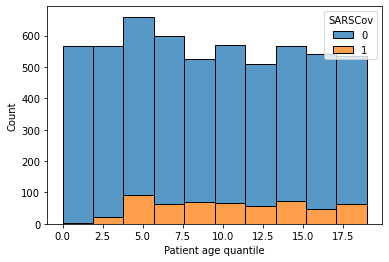

In [332]:
sns.histplot(data=covid_df, x='Patient age quantile',  bins=10, hue='SARSCov', multiple="stack") #hue='SARSCov'

In [333]:
covid_df.shape

(5644, 110)

In [334]:
display_all(covid_df.isna().sum())

Patient age quantile                                        0
SARSCov                                                     0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
Patient addmited to intensive care unit (1=yes, 0=no)       0
Hematocrit                                               5041
Hemoglobin                                               5041
Platelets                                                5042
Mean platelet volume                                     5045
Red blood Cells                                          5042
Lymphocytes                                              5042
Mean corpuscular hemoglobin concentration (MCHC)         5042
Leukocytes                                               5042
Basophils                                                5042
Mean corpuscular hemoglobin (MCH)                        5042
Eosinophils                                              5042
Mean cor

In [335]:
df = covid_df[covid_df['Hemoglobin'].notna()]

In [336]:
df.shape

(603, 110)

In [337]:
df.shape[0]-236

367

In [338]:
df = df.dropna(thresh=367, axis=1) # thresh - require that many non-NA values

In [729]:
df.SARSCov.value_counts()

0    520
1     83
Name: SARSCov, dtype: int64

In [340]:
df.dtypes.value_counts()

float64    20
int64       5
dtype: int64

In [341]:
df.select_dtypes(['int64']).isna().sum()

Patient age quantile                                     0
SARSCov                                                  0
Patient addmited to regular ward (1=yes, 0=no)           0
Patient addmited to semi-intensive unit (1=yes, 0=no)    0
Patient addmited to intensive care unit (1=yes, 0=no)    0
dtype: int64

In [342]:
display_all(df.select_dtypes(['float64']).isna().sum())

Hematocrit                                            0
Hemoglobin                                            0
Platelets                                             1
Mean platelet volume                                  4
Red blood Cells                                       1
Lymphocytes                                           1
Mean corpuscular hemoglobin concentration (MCHC)      1
Leukocytes                                            1
Basophils                                             1
Mean corpuscular hemoglobin (MCH)                     1
Eosinophils                                           1
Mean corpuscular volume (MCV)                         1
Monocytes                                             2
Red blood cell distribution width (RDW)               1
Neutrophils                                          90
Urea                                                207
Proteina C reativa mg/dL                            101
Creatinine                                      

<AxesSubplot:xlabel='Patient age quantile', ylabel='Count'>

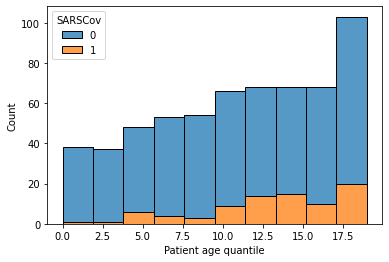

In [343]:
sns.histplot(data=df, x='Patient age quantile', bins=10, hue='SARSCov', multiple="stack")

In [344]:
X = df.drop(df.columns[[1,2,3,4]], axis=1).copy()
y = df.SARSCov.copy()

In [347]:
pd.options.display.float_format = "{:,.2f}".format

In [730]:
X

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
1,17,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,...,1.48,0.17,0.36,-0.63,-0.62,1.20,-0.15,2.09,-0.31,0.86
8,1,-1.57,-0.77,1.43,-1.67,-0.85,-0.01,3.33,0.36,-0.22,...,1.02,-1.34,0.07,-0.98,-0.13,-0.07,-0.29,-1.84,0.93,0.50
15,9,-0.75,-0.59,-0.43,-0.21,-1.36,-1.11,0.54,-0.88,0.08,...,-0.67,1.67,1.28,-1.07,0.88,-0.81,nan,-0.91,0.44,-0.22
18,11,0.99,0.79,0.07,-0.55,0.54,0.05,-0.45,-0.21,-0.83,...,-0.71,0.61,-0.22,0.17,0.27,nan,-0.49,nan,nan,nan
22,9,0.19,-0.15,-0.67,1.02,-0.13,0.00,-1.25,-1.13,0.39,...,-0.71,0.57,2.01,0.61,-0.42,-1.33,nan,-0.91,-0.55,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,19,0.19,0.17,-0.10,0.91,0.38,-1.58,-0.05,-0.33,-0.83,...,0.89,-0.47,1.07,0.35,1.12,0.38,3.63,0.47,0.19,-5.25
5614,19,-0.29,-0.52,0.66,-0.77,0.75,-1.53,-1.05,1.57,0.08,...,-0.54,-1.98,1.67,0.97,1.13,-0.07,5.73,0.50,-0.55,-0.22
5615,15,0.72,1.11,-0.49,-0.21,0.61,0.00,1.54,-0.55,-0.22,...,-0.71,0.01,0.91,-1.16,-0.06,-0.37,0.56,-0.49,0.44,0.14
5618,17,-3.24,-2.78,-1.77,-0.55,-3.32,-1.83,1.54,-1.73,-1.14,...,-0.58,1.41,1.38,-0.45,1.55,2.24,0.61,0.47,-0.31,-1.29


In [ ]:
# main = ['Leukocytes', 'Platelets', 'Eosinophils', 'Monocytes', 'Proteina C reativa mg/dL']

In [353]:
X[y==0].describe()

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
count,520.00,520.00,520.00,519.00,518.00,519.00,519.00,519.00,519.00,519.00,...,519.00,519.00,518.00,519.00,438.00,337.00,433.00,361.00,312.00,310.00
mean,10.79,-0.04,-0.04,0.11,-0.04,-0.05,0.01,-0.02,0.12,0.03,...,0.08,0.02,-0.08,0.02,0.02,0.03,-0.03,-0.03,0.04,0.04
std,5.81,1.02,1.02,1.00,1.01,1.00,1.02,1.01,1.00,1.04,...,1.04,0.99,0.95,1.01,1.01,1.05,1.01,1.03,1.02,1.01
min,0.00,-4.50,-4.35,-2.55,-2.46,-3.97,-1.87,-5.43,-2.02,-1.14,...,-0.84,-4.58,-2.16,-1.60,-3.34,-1.63,-0.54,-2.39,-2.28,-5.25
25%,6.00,-0.59,-0.59,-0.50,-0.77,-0.60,-0.74,-0.65,-0.55,-0.53,...,-0.62,-0.53,-0.64,-0.63,-0.65,-0.59,-0.52,-0.67,-0.80,-0.58
50%,11.00,0.02,-0.02,0.02,-0.10,-0.00,0.00,-0.05,-0.08,-0.22,...,-0.25,0.09,-0.22,-0.18,-0.06,-0.14,-0.41,-0.12,-0.06,0.14
75%,16.00,0.69,0.67,0.64,0.68,0.62,0.61,0.64,0.55,0.69,...,0.43,0.65,0.38,0.35,0.71,0.45,-0.05,0.50,0.68,0.77
max,19.00,2.66,2.67,9.53,3.71,3.65,3.76,3.33,4.52,11.08,...,8.35,3.41,4.53,6.98,2.54,11.25,8.03,5.05,3.40,4.10


In [352]:
X[y!=0].describe()

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
count,83.00,83.00,83.00,83.00,81.00,83.00,83.00,83.00,83.00,83.00,...,83.00,83.00,83.00,83.00,75.00,59.00,69.00,62.00,58.00,58.00
mean,13.33,0.25,0.26,-0.71,0.28,0.30,-0.04,0.11,-0.72,-0.16,...,-0.48,-0.14,0.49,-0.10,-0.09,-0.17,0.19,0.20,-0.20,-0.22
std,4.59,0.80,0.83,0.65,0.90,0.96,0.87,0.91,0.66,0.74,...,0.45,1.06,1.15,0.95,0.92,0.68,0.95,0.75,0.86,0.92
min,1.00,-1.78,-1.65,-2.06,-1.90,-1.66,-1.69,-3.44,-1.48,-1.14,...,-0.84,-5.10,-2.06,-1.33,-2.23,-1.41,-0.53,-1.67,-2.04,-2.37
25%,11.00,-0.42,-0.37,-1.10,-0.33,-0.40,-0.68,-0.45,-1.12,-0.53,...,-0.77,-0.45,-0.26,-0.76,-0.70,-0.66,-0.46,-0.32,-0.80,-0.93
50%,14.00,0.35,0.42,-0.72,0.24,0.28,-0.07,0.14,-0.83,-0.22,...,-0.67,-0.05,0.52,-0.27,-0.03,-0.29,-0.25,0.11,-0.31,-0.22
75%,17.00,0.93,0.89,-0.34,0.80,0.93,0.56,0.74,-0.55,0.08,...,-0.33,0.42,1.16,0.26,0.52,0.34,0.37,0.67,0.44,0.50
max,19.00,1.66,1.92,1.76,2.70,2.98,2.15,1.94,3.61,2.22,...,1.06,2.11,3.64,4.95,1.89,1.94,3.51,1.95,1.67,1.94


# Pre-processing

In [354]:
imputer = KNNImputer(n_neighbors=7)
X_imputed = imputer.fit_transform(X)

In [355]:
X_imputed = pd.DataFrame(data=X_imputed, columns=X.columns)

# Feature importance

In [731]:
m = ExtraTreesClassifier(n_estimators=125, max_features=0.5, n_jobs=-1, oob_score=True, bootstrap=True)
m.fit(X_imputed, y)
m.oob_score_

0.8772802653399668

In [732]:
fi = rf_feat_importance(m, X_imputed)

In [733]:
fi

,cols,imp
8,Leukocytes,0.14
3,Platelets,0.09
11,Eosinophils,0.07
13,Monocytes,0.06
17,Proteina C reativa mg/dL,0.06
0,Patient age quantile,0.05
18,Creatinine,0.04
4,Mean platelet volume,0.04
19,Potassium,0.04
5,Red blood Cells,0.04


<AxesSubplot:ylabel='cols'>

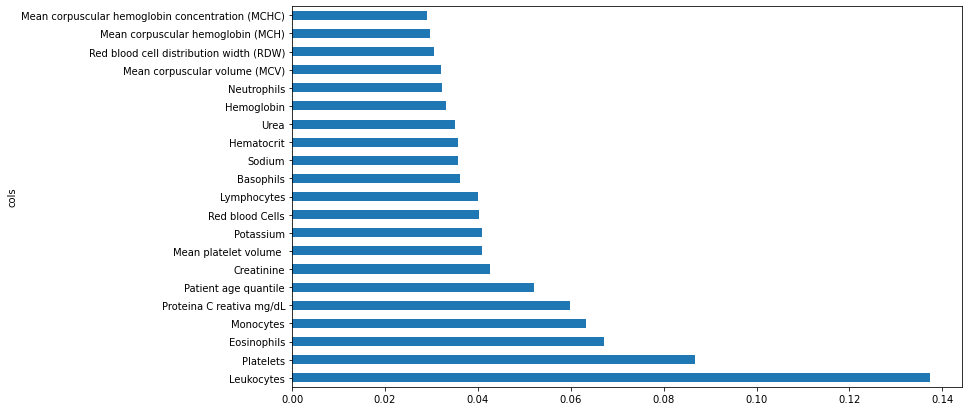

In [735]:
plot_fi(fi)

<AxesSubplot:xlabel='cols'>

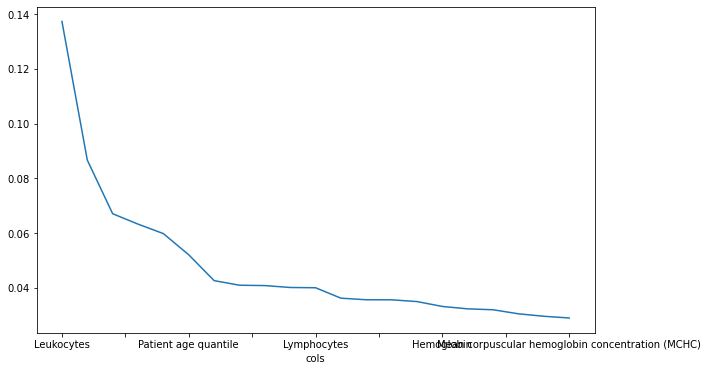

In [734]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [675]:
to_keep = fi[fi.imp>0.035].cols; len(to_keep)

15

In [676]:
df_keep = X_imputed[to_keep]

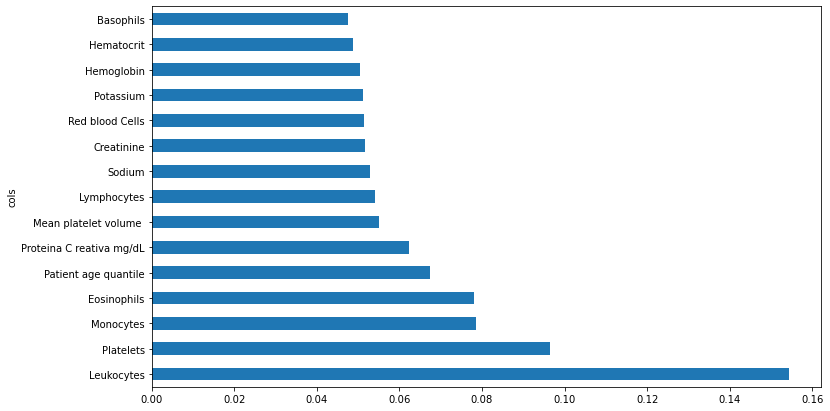

In [677]:
m.fit(df_keep, y)
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [493]:
fi

,cols,imp
0,Leukocytes,0.15
1,Platelets,0.10
2,Eosinophils,0.09
3,Monocytes,0.08
4,Patient age quantile,0.07
5,Proteina C reativa mg/dL,0.06
8,Red blood Cells,0.06
7,Creatinine,0.05
6,Mean platelet volume,0.05
9,Hematocrit,0.05


# Plot

In [743]:
main = ['Leukocytes', 'Platelets', 'Eosinophils', 'Monocytes', 'Proteina C reativa mg/dL']

In [744]:
visual = X_imputed[main].copy()

In [745]:
visual.rename(columns={'Proteina C reativa mg/dL':'CRP'}, inplace=True)

In [746]:
visual['SARSCov'] = y.values

0         AxesSubplot(0.1,0.15;0.363636x0.75)
1    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

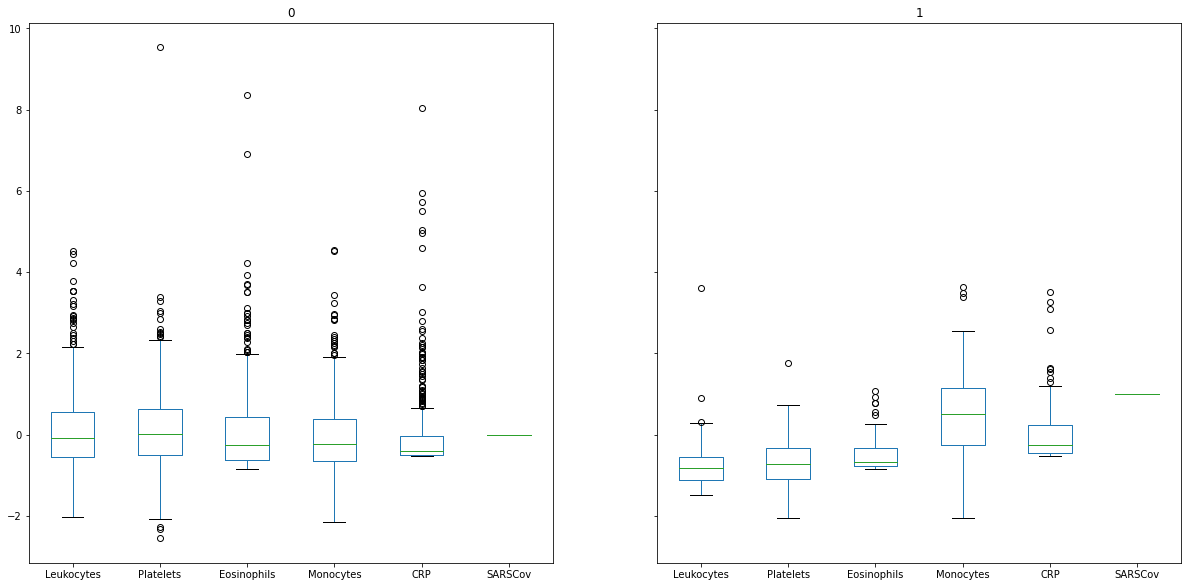

In [747]:
visual.groupby("SARSCov").boxplot(figsize=(20,10), grid=False)

In [748]:
y.value_counts()

0    520
1     83
Name: SARSCov, dtype: int64

# Outliers detect

In [24]:
outlier_detect = IsolationForest(n_estimators=150, max_samples=621, contamination=float(0.07), max_features=X_imputed.shape[1])

outlier_detect.fit(X_imputed)
outliers_predicted = outlier_detect.predict(X_imputed)

# covid_check = dataframe[outlier_detect.predict(dataframe) == -1]

# dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

/home/vytas/anaconda3/envs/COLAB/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:285: UserWarning: max_samples (621) is greater than the total number of samples (603). max_samples will be set to n_samples for estimation.
  warn("max_samples (%s) is greater than the "


In [26]:
X_imputed[outlier_detect.predict(X_imputed) == -1]

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
32,0.0,-0.862136,-0.648900,1.630656,0.347255,-1.255533,2.928253,0.742040,-0.431328,-0.529226,...,1.566437,1.127610,1.014127,1.674795,-3.339775,-0.258709,-0.265129,-1.370938,-0.093935,-0.010268
54,3.0,-0.793470,-0.899524,-1.183189,2.591120,-0.814774,-1.711547,-0.652057,-0.962841,-1.140144,...,-0.751229,0.186222,-0.193981,-0.448160,1.962290,-0.960510,0.032923,-0.598028,-2.283079,-2.012527
79,19.0,1.106281,0.854844,-0.894267,1.020415,0.384090,-1.268037,-0.652057,3.152908,-1.140144,...,-0.414114,1.147641,-1.008140,1.940165,1.378115,2.910027,5.946270,5.053572,1.177181,0.503132
104,13.0,2.136267,2.483899,0.675959,1.356995,1.565324,0.540121,1.538664,1.068597,4.663579,...,0.175837,0.546754,0.305020,0.259492,-0.799373,0.070925,-0.366466,0.485031,-0.411714,0.246432
176,18.0,0.694287,0.980156,0.273981,0.683835,0.119635,0.309837,1.239930,-0.837616,1.303529,...,8.350876,0.967375,-0.640455,-0.448160,-1.709001,1.070459,-0.507544,0.248727,0.682859,1.581271
246,19.0,-2.166785,-1.902020,-1.321369,1.917961,-2.330985,0.599824,0.642463,-0.481418,0.692611,...,0.850067,1.087552,-0.824298,0.613318,-0.422410,4.175395,-0.487674,2.710226,3.401635,-0.575008
283,18.0,-2.029454,-1.526084,0.361914,0.683835,-2.895156,2.459156,1.936978,-0.893272,0.081693,...,-0.203417,3.410980,1.907076,0.171035,-2.872669,1.038559,-0.048828,0.194574,0.576932,0.143752
293,4.0,-2.052342,-1.651396,1.366858,-1.223449,-2.189942,-0.116616,1.339507,0.155841,-0.529226,...,-0.793368,0.967375,1.355549,-0.005877,-0.061837,-1.183810,2.554441,-0.563567,2.165828,0.503132
307,13.0,-1.640348,-2.089987,1.178431,-0.999063,-0.585580,-1.387443,-2.643618,1.483233,-0.834685,...,-0.793368,-2.017030,-1.717247,2.028622,2.126187,-0.439476,-0.223401,-0.908177,1.424343,-2.012527
340,11.0,-1.205464,-1.275460,1.567847,2.254541,-0.444537,-1.327740,-0.652057,2.162234,-0.529226,...,0.260116,-1.436172,-1.349562,3.532382,1.741029,-1.555977,-0.362492,-0.666950,0.435697,-0.215628


# SMOTE

In [356]:
sm = SMOTE()
X_imputed_oversampled, y_oversampled = sm.fit_sample(X_imputed, y)

In [358]:
X_imputed_oversampled

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,...,Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium
0,17.00,0.24,-0.02,-0.52,0.01,0.10,0.32,-0.95,-0.09,-0.22,...,1.48,0.17,0.36,-0.63,-0.62,1.20,-0.15,2.09,-0.31,0.86
1,1.00,-1.57,-0.77,1.43,-1.67,-0.85,-0.01,3.33,0.36,-0.22,...,1.02,-1.34,0.07,-0.98,-0.13,-0.07,-0.29,-1.84,0.93,0.50
2,9.00,-0.75,-0.59,-0.43,-0.21,-1.36,-1.11,0.54,-0.88,0.08,...,-0.67,1.67,1.28,-1.07,0.88,-0.81,-0.02,-0.91,0.44,-0.22
3,11.00,0.99,0.79,0.07,-0.55,0.54,0.05,-0.45,-0.21,-0.83,...,-0.71,0.61,-0.22,0.17,0.27,0.05,-0.49,0.05,0.26,0.71
4,9.00,0.19,-0.15,-0.67,1.02,-0.13,0.00,-1.25,-1.13,0.39,...,-0.71,0.57,2.01,0.61,-0.42,-1.33,-0.42,-0.91,-0.55,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,17.45,0.47,0.33,-1.19,1.83,0.34,-0.52,-0.39,-0.90,-0.53,...,-0.54,0.11,1.25,-0.03,0.31,-0.25,-0.02,0.28,0.10,-0.46
1036,12.57,0.50,0.41,-0.65,-0.58,0.46,0.97,-0.19,-0.86,0.39,...,-0.01,-0.09,0.85,-0.35,-1.12,0.03,-0.09,1.34,0.30,0.97
1037,13.00,0.33,0.50,-1.30,1.20,-0.06,0.08,0.72,-1.10,-0.88,...,-0.44,0.73,3.57,-0.60,-1.01,-0.58,-0.19,-0.37,-0.45,-0.05
1038,19.00,-0.26,-0.42,-0.33,0.42,-0.52,-0.11,-0.71,-0.65,1.65,...,-0.67,0.60,1.00,1.75,-0.04,0.73,1.27,1.25,0.68,-1.29


# Models

## Extra trees 

### Bagging

In [779]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.1, random_state=0)

In [780]:
m = ExtraTreesClassifier(n_jobs=-1, n_estimators=400, max_features=0.5, min_samples_leaf=1, bootstrap=True, oob_score=True)
m.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_features=0.5, n_estimators=400,
                     n_jobs=-1, oob_score=True)

In [781]:
preds = np.stack([t.predict(X_test) for t in m.estimators_])

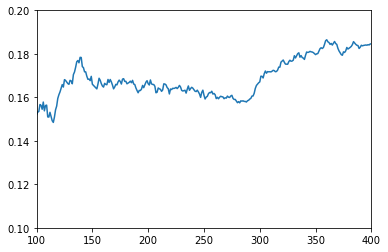

In [784]:
plt.xlim(100, 400)
plt.ylim(0.1, 0.2)
plt.plot([metrics.r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(400)])

In [778]:
m.oob_score_

0.8819188191881919

### Randomized parameter search

In [786]:
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 0.5, None] # sqrt = auto

# Maximum number of levels in tree
min_samples_leaf = [1, 3, 5, 10] #25, 100

random_grid = {'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
               #'n_estimators': n_estimators}

print(random_grid)

rf = ExtraTreesClassifier(n_estimators=350) #ExtraTrees
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 5, verbose=2, random_state=10, n_jobs=-1) #scoring = 'precision_weighted'

search = rf_random.fit(X_imputed, y)
print('Par:', search.best_params_)
print('Score:', search.best_score_)

{'min_samples_leaf': [1, 3, 5, 10], 'max_features': ['log2', 'sqrt', 0.5, None]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished


Par: {'min_samples_leaf': 1, 'max_features': None}
Score: 0.887314049586777


In [788]:
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 0.5, None] # sqrt = auto

# Maximum number of levels in tree
min_samples_leaf = [1, 3, 5, 10] #25, 100

random_grid = {'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
               #'n_estimators': n_estimators}

print(random_grid)

rf = ExtraTreesClassifier(n_estimators=350) #ExtraTrees
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 5, verbose=2, random_state=10, n_jobs=-1) #scoring = 'precision_weighted'

search = rf_random.fit(X_imputed_oversampled, y_oversampled)
print('Par:', search.best_params_)
print('Score:', search.best_score_)

{'min_samples_leaf': [1, 3, 5, 10], 'max_features': ['log2', 'sqrt', 0.5, None]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished


Par: {'min_samples_leaf': 1, 'max_features': 0.5}
Score: 0.9605769230769232


In [832]:
et = ExtraTreesClassifier(n_estimators=350, max_features=0.5, n_jobs=-1, oob_score=True, bootstrap=True)
et.fit(X_imputed_oversampled, y_oversampled)

ExtraTreesClassifier(bootstrap=True, max_features=0.5, n_estimators=350,
                     n_jobs=-1, oob_score=True)

# Catboost

In [790]:
from catboost import CatBoostClassifier
from catboost import CatBoost

In [822]:
grid = {'n_estimators': [1000],
        'learning_rate': [0.04, 0.05],
        'depth': [4],
        'l2_leaf_reg': [9, 12]}

cb = CatBoostClassifier(verbose=1000) #ExtraTrees
cb_random = RandomizedSearchCV(estimator = cb, param_distributions = grid,
                               cv = 5, verbose=2, random_state=10, n_jobs=21) #scoring = 'precision_weighted'

search = cb_random.fit(X_imputed_oversampled, y_oversampled)
print('Par:', search.best_params_)
print('Score:', search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/vytas/anaconda3/envs/COLAB/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=21)]: Using backend LokyBackend with 21 concurrent workers.
[Parallel(n_jobs=21)]: Done  12 out of  20 | elapsed:   10.3s remaining:    6.8s
[Parallel(n_jobs=21)]: Done  20 out of  20 | elapsed:   10.4s finished


0:	learn: 0.6576775	total: 2.5ms	remaining: 2.5s
999:	learn: 0.0234114	total: 1.68s	remaining: 0us
Par: {'n_estimators': 1000, 'learning_rate': 0.05, 'l2_leaf_reg': 12, 'depth': 4}
Score: 0.9423076923076923


In [ ]:
# model = CatBoost()
# grid = {'learning_rate': [0.005, 0.01],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 5, 9]}

In [833]:
cb = CatBoostClassifier(random_state=0, verbose=1000, learning_rate=0.05, l2_leaf_reg=12, depth=4, n_estimators=1000, early_stopping_rounds=5) #logging_level='Silent' learning_rate=0.008, n_estimators=1000,
cb.fit(X_imputed_oversampled, y_oversampled)

0:	learn: 0.6576775	total: 1.93ms	remaining: 1.93s
999:	learn: 0.0234114	total: 934ms	remaining: 0us


# XGBoost

In [823]:
from xgboost import XGBClassifier

In [834]:
xgb = XGBClassifier(n_estimators=500, n_jobs=20)

In [835]:
xgb.fit(X_imputed_oversampled, y_oversampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [868]:
grid = {'n_estimators': [1100, 1300, 1400, 1500],
        "learning_rate": [0.17, 0.18, 0.19],
        "max_depth": [60, 70, 80],
        "min_child_weight": [1, 3]}

xgb = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = grid,
                               cv = 5, n_iter = 100, verbose=2, random_state=10, n_jobs=21) #scoring = 'precision_weighted'

search = xgb_random.fit(X_imputed_oversampled, y_oversampled)
print('Par:', search.best_params_)
print('Score:', search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=21)]: Using backend LokyBackend with 21 concurrent workers.
[Parallel(n_jobs=21)]: Done 120 tasks      | elapsed:    6.2s
[Parallel(n_jobs=21)]: Done 323 tasks      | elapsed:   15.6s
[Parallel(n_jobs=21)]: Done 500 out of 500 | elapsed:   23.9s finished


Par: {'n_estimators': 1400, 'min_child_weight': 1, 'max_depth': 60, 'learning_rate': 0.18}
Score: 0.9423076923076923


# LightGBM

In [841]:
from lightgbm import LGBMClassifier

In [842]:
lgbm = LGBMClassifier()

In [843]:
lgbm.fit(X_imputed_oversampled, y_oversampled)

LGBMClassifier()

In [876]:
grid = {'learning_rate': [0.13, 0.14, 0.15, 0.16, 0,17],
    'n_estimators': [1200, 1300, 1400],
    'num_leaves': [130, 175, 190, 250, 300],
    'boosting_type' : ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [8, 10, 12, 14]
    }

lgbm = LGBMClassifier()
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = grid,
                               cv = 5, n_iter = 100, verbose=2, random_state=10, n_jobs=21) #scoring = 'precision_weighted'

search = lgbm_random.fit(X_imputed_oversampled, y_oversampled)
print('Par:', search.best_params_)
print('Score:', search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=21)]: Using backend LokyBackend with 21 concurrent workers.
[Parallel(n_jobs=21)]: Done 162 tasks      | elapsed:   23.1s
[Parallel(n_jobs=21)]: Done 365 tasks      | elapsed:   38.4s
[Parallel(n_jobs=21)]: Done 500 out of 500 | elapsed:   49.1s finished


Par: {'objective': 'binary', 'num_leaves': 300, 'n_estimators': 1300, 'max_depth': 10, 'learning_rate': 0.14, 'boosting_type': 'dart'}
Score: 0.9567307692307694


In [874]:
grid = {'learning_rate': [0.13, 0.14, 0.15, 0.16, 0,17, 0,18],
    'n_estimators': [1100, 1300, 1500, 2000],
    'num_leaves': [130, 175, 190, 250, 300],
    'boosting_type' : ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [8, 10, 12, 14, 16]
    }

lgbm = LGBMClassifier()
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = grid,
                               cv = 5, n_iter = 100, verbose=2, random_state=10, n_jobs=21) #scoring = 'precision_weighted'

search = lgbm_random.fit(X_imputed_oversampled, y_oversampled)
print('Par:', search.best_params_)
print('Score:', search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=21)]: Using backend LokyBackend with 21 concurrent workers.
[Parallel(n_jobs=21)]: Done 120 tasks      | elapsed:    7.7s
[Parallel(n_jobs=21)]: Done 323 tasks      | elapsed:   26.9s
[Parallel(n_jobs=21)]: Done 500 out of 500 | elapsed:   46.9s finished


Par: {'objective': 'binary', 'num_leaves': 175, 'n_estimators': 1300, 'max_depth': 10, 'learning_rate': 0.14, 'boosting_type': 'dart'}
Score: 0.9567307692307694


# Main splits

In [545]:
m = RandomForestClassifier(n_estimators=5, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_imputed_oversampled, y_oversampled)

RandomForestClassifier(bootstrap=False, max_depth=3, n_estimators=5, n_jobs=-1)

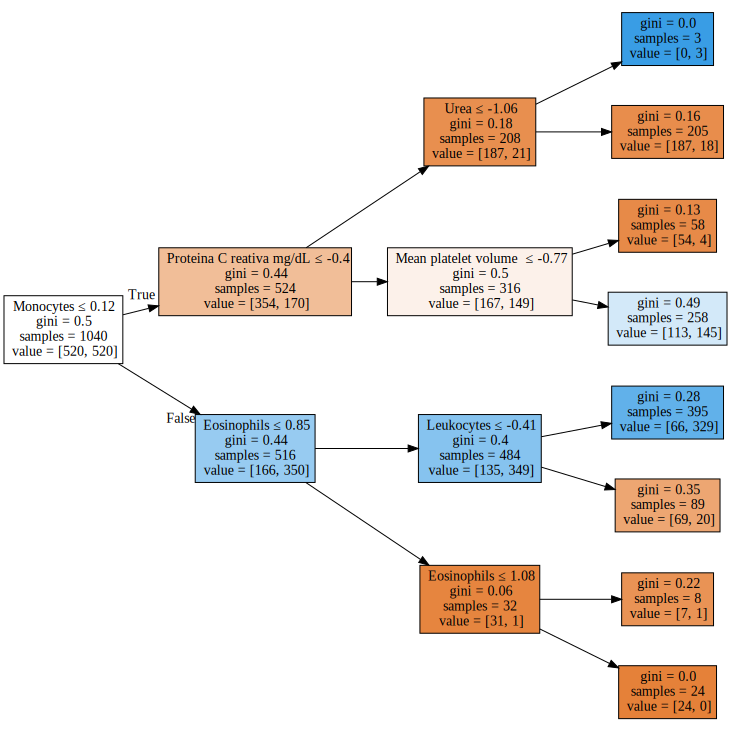

In [546]:
draw_tree(m.estimators_[0], X_imputed, size=12, ratio=0.99999, precision=2)

# Feature importance SMOTE


In [805]:
m = ExtraTreesClassifier(n_estimators=350, max_features=0.5, oob_score=True, bootstrap=True, n_jobs=-1)
m.fit(X_imputed_oversampled, y_oversampled)

ExtraTreesClassifier(bootstrap=True, max_features=0.5, n_estimators=350,
                     n_jobs=-1, oob_score=True)

In [806]:
m.oob_score_

0.9576923076923077

In [807]:
fi = rf_feat_importance(m, X_imputed_oversampled)

In [808]:
fi

,cols,imp
8,Leukocytes,0.18
3,Platelets,0.14
11,Eosinophils,0.08
13,Monocytes,0.06
0,Patient age quantile,0.05
4,Mean platelet volume,0.05
17,Proteina C reativa mg/dL,0.04
9,Basophils,0.04
18,Creatinine,0.04
1,Hematocrit,0.03


<AxesSubplot:xlabel='cols'>

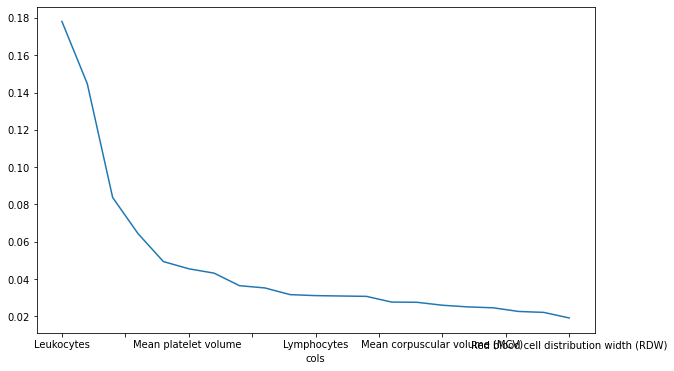

In [809]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [810]:
to_keep = fi[fi.imp>0.035].cols; len(to_keep)

9

In [811]:
df_keep_oversampled = X_imputed_oversampled[to_keep]

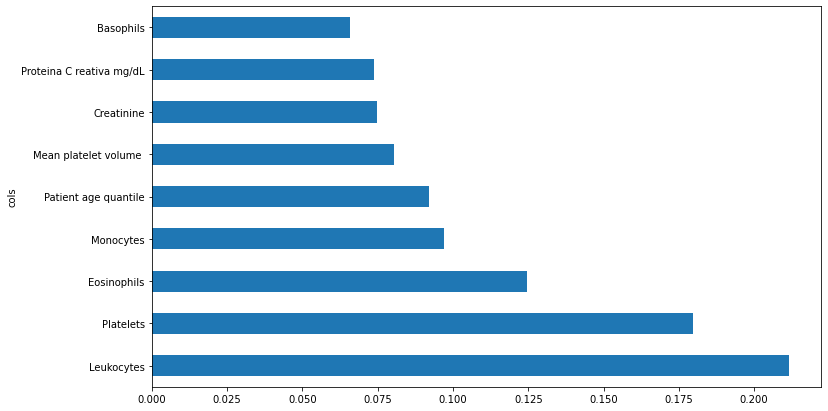

In [812]:
m.fit(df_keep_oversampled, y_oversampled)
fi = rf_feat_importance(m, df_keep_oversampled)
plot_fi(fi);

In [667]:
fi

,cols,imp
0,Leukocytes,0.23
1,Platelets,0.18
2,Eosinophils,0.14
3,Monocytes,0.10
4,Patient age quantile,0.10
7,Creatinine,0.08
5,Mean platelet volume,0.08
6,Proteina C reativa mg/dL,0.08


# Feature similarities

In [548]:
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr as sp

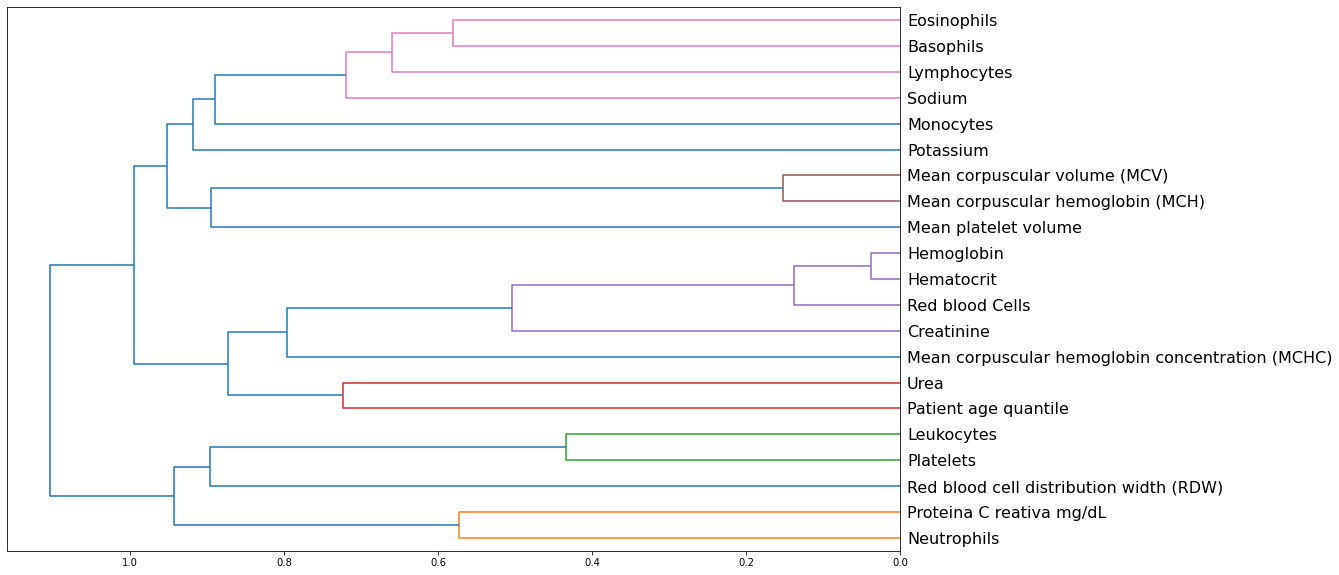

In [549]:
corr = np.round(sp(X_imputed_oversampled).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_imputed_oversampled.columns, orientation='left', leaf_font_size=16)
plt.show()

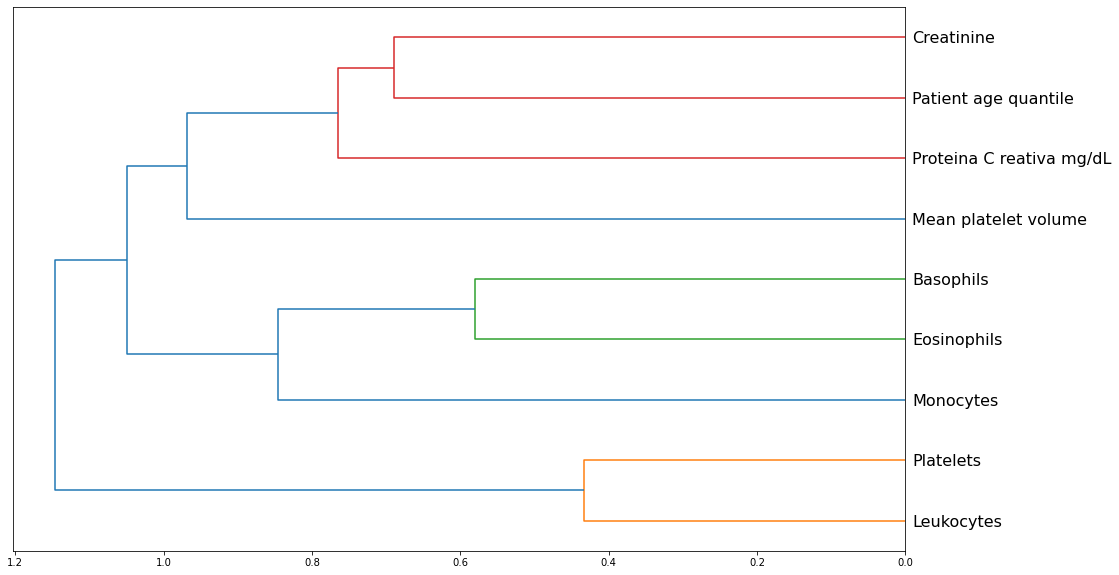

In [552]:
corr = np.round(sp(df_keep_oversampled).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep_oversampled.columns, orientation='left', leaf_font_size=16)
plt.show()

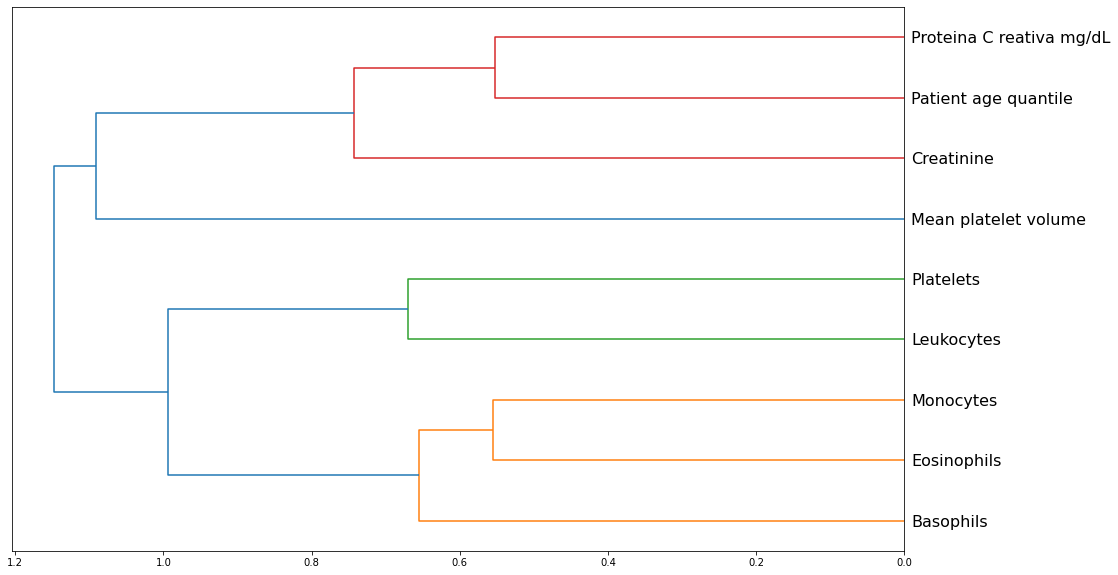

In [553]:
corr = np.round(sp(df_keep_oversampled[y_oversampled!=0]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep_oversampled.columns, orientation='left', leaf_font_size=16)
plt.show()

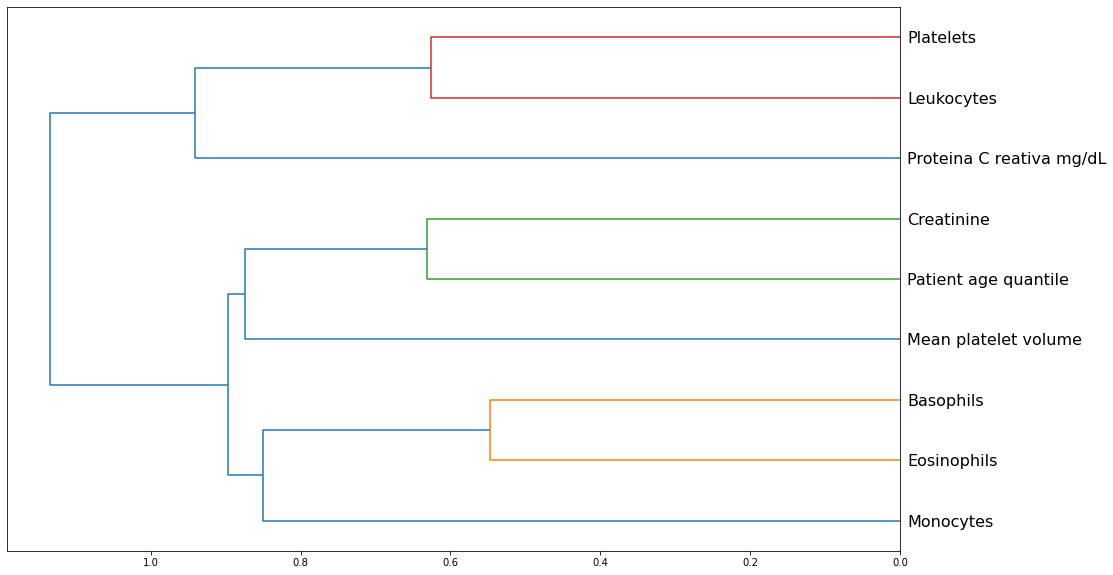

In [554]:
corr = np.round(sp(df_keep_oversampled[y_oversampled==0]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep_oversampled.columns, orientation='left', leaf_font_size=16)
plt.show()

In [550]:
import hdbscan
data = imputed_oversampled

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True)
clusterer.fit(data)

ModuleNotFoundError: No module named 'hdbscan'

In [1]:
models = [
    ExtraTreesClassifier(n_estimators=300, max_depth=17),
    RandomForestClassifier(n_estimators=300, max_depth=17),
    LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
                        class_weight='balanced')
]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    sm = SMOTE(k_neighbors=11)
    x_res, y_res = sm.fit_sample(X_train, y_train)

    S_train, S_test = stacking(models,
                               x_res, y_res, X_test,
                               regression=False,
                               mode='oof_pred',
                               needs_proba=False,
                               save_dir=None,
                               metric=metrics.accuracy_score,
                               n_folds=10,
                               stratified=True,
                               shuffle=True,
                               verbose=2)

    model = XGBClassifier(learning_rate=1.0,
                          n_estimators=300, max_depth=17)

    # fit model
    model = model.fit(S_train, y_res)

	# evaluate model
    y_pred = model.predict(S_test)
    score = metrics.accuracy_score(y_test, y_pred)

    accuracies_stats.append(score)

    probs = model.predict_proba(S_test)
    probs = probs[:, 1]
    AUC_stats.append(metrics.roc_auc_score(y_test, probs))

    pre_stats.append(metrics.precision_score(y_test, y_pred, average='binary'))
    recall_stats.append(metrics.recall_score(y_test, y_pred, average='binary'))
    f1_stats.append(metrics.f1_score(y_test, y_pred, average='binary'))

    confusion = metrics.confusion_matrix(y_test, y_pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # recall of the positive
    sensitivity = TP / float(FN + TP)

    # recall of the negative class
    specificity = TN / (TN + FP)

    sensitivity_stats.append(sensitivity)
    specificity_stats.append(specificity)

    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)

print("Average TP  = {}".format(np.round(np.array(TP_list).mean(), 4)))
print("Average TN  = {}".format(np.round(np.array(TN_list).mean(), 4)))
print("Average FP  = {}".format(np.round(np.array(FP_list).mean(), 4)))
print("Average FN  = {}".format(np.round(np.array(FN_list).mean(), 4)))

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(accuracies_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(accuracies_stats, p))

print("Average accuracy  = {}".format(np.round(np.array(accuracies_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(AUC_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(AUC_stats, p))

print("Average AUC       = {}".format(np.round(np.array(AUC_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(pre_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(pre_stats, p))
print("Average precision = {}".format(np.round(np.array(pre_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(recall_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(recall_stats, p))
print("Average recall    = {}".format(np.round(np.array(recall_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(f1_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(f1_stats, p))
print("Average f1 score = {}".format(np.round(np.array(f1_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(sensitivity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(sensitivity_stats, p))
print("Sensitivity score = {}".format(np.round(np.array(sensitivity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(specificity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(specificity_stats, p))
print("Specificity score = {}".format(np.round(np.array(specificity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


In [14]:
# %load ERLX.py
#!/usr/bin/python

import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

# load dataset
covid_df   = pd.read_csv("covid_data.csv")
covid_cols = ["SARSCov", "Hemoglobin", "Platelets", "Leukocytes",
                     "Lymphocytes", "Basophils", "Eosinophils", "Neutrophils",
                     "Monocytes", "Patient age quantile", "Urea", "Proteina C reativa mg/dL",
                     "Creatinine", "Potassium", "Sodium", "Alanine transaminase",
                     "Aspartate transaminase", "International normalized ratio (INR)",
                     "Albumin"]

covid_df = covid_df[covid_cols]

models = [
    ExtraTreesClassifier(n_estimators=300, max_depth=17),
    RandomForestClassifier(n_estimators=300, max_depth=17),
    LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
                        class_weight='balanced')
]

# configure bootstrap
n_iterations = 1

accuracies_stats  = list()
AUC_stats         = list()
pre_stats         = list()
recall_stats      = list()
f1_stats          = list()
sensitivity_stats = list()
specificity_stats = list()
TP_list = list()
TN_list = list()
FP_list = list()
FN_list = list()

for i in range(n_iterations):

    imputer = KNNImputer(n_neighbors=7)
    Ximputer = imputer.fit_transform(covid_df)
    dataframe=pd.DataFrame(Ximputer, columns=covid_cols)

    outlier_detect = IsolationForest(n_estimators=150, max_samples=621, contamination=float(0.07), max_features=covid_df.shape[1])

    outlier_detect.fit(dataframe)
    outliers_predicted = outlier_detect.predict(dataframe)

    covid_check = dataframe[outlier_detect.predict(dataframe) == -1]

    dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

    values = dataframe.values

    n_size = int(len(dataframe) * 0.80)
	# prepare train and test sets
    data_sample = resample(values, n_samples=n_size)

    dataframe = pd.DataFrame(data_sample, columns=covid_cols)
    # split into input and output elements
    y = dataframe.SARSCov # Target variable
    X = dataframe.drop(['SARSCov'], axis = 1) # Features

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    sm = SMOTE(k_neighbors=11)
    x_res, y_res = sm.fit_sample(X_train, y_train)

    S_train, S_test = stacking(models,
                               x_res, y_res, X_test,
                               regression=False,

                               mode='oof_pred',

                               needs_proba=False,

                               save_dir=None,

                               metric=metrics.accuracy_score,

                               n_folds=10,

                               stratified=True,

                               shuffle=True,

                               verbose=2)

    model = XGBClassifier(learning_rate=1.0,
                          n_estimators=300, max_depth=17)

    # fit model
    model = model.fit(S_train, y_res)

	# evaluate model
    y_pred = model.predict(S_test)
    score = metrics.accuracy_score(y_test, y_pred)

    accuracies_stats.append(score)

    probs = model.predict_proba(S_test)
    probs = probs[:, 1]
    AUC_stats.append(metrics.roc_auc_score(y_test, probs))

    pre_stats.append(metrics.precision_score(y_test, y_pred, average='binary'))
    recall_stats.append(metrics.recall_score(y_test, y_pred, average='binary'))
    f1_stats.append(metrics.f1_score(y_test, y_pred, average='binary'))

    confusion = metrics.confusion_matrix(y_test, y_pred)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # recall of the positive
    sensitivity = TP / float(FN + TP)

    # recall of the negative class
    specificity = TN / (TN + FP)

    sensitivity_stats.append(sensitivity)
    specificity_stats.append(specificity)

    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)

print("Average TP  = {}".format(np.round(np.array(TP_list).mean(), 4)))
print("Average TN  = {}".format(np.round(np.array(TN_list).mean(), 4)))
print("Average FP  = {}".format(np.round(np.array(FP_list).mean(), 4)))
print("Average FN  = {}".format(np.round(np.array(FN_list).mean(), 4)))

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(accuracies_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(accuracies_stats, p))

print("Average accuracy  = {}".format(np.round(np.array(accuracies_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(AUC_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(AUC_stats, p))

print("Average AUC       = {}".format(np.round(np.array(AUC_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(pre_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(pre_stats, p))
print("Average precision = {}".format(np.round(np.array(pre_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(recall_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(recall_stats, p))
print("Average recall    = {}".format(np.round(np.array(recall_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(f1_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(f1_stats, p))
print("Average f1 score = {}".format(np.round(np.array(f1_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(sensitivity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(sensitivity_stats, p))
print("Sensitivity score = {}".format(np.round(np.array(sensitivity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(specificity_stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(specificity_stats, p))
print("Specificity score = {}".format(np.round(np.array(specificity_stats).mean(), 4)))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred]
n_models:     [3]

model  0:     [ExtraTreesClassifier]
    fold  0:  [1.00000000]
    fold  1:  [1.00000000]
    fold  2:  [1.00000000]
    fold  3:  [1.00000000]
    fold  4:  [1.00000000]
    fold  5:  [1.00000000]
    fold  6:  [0.99838969]
    fold  7:  [1.00000000]
    fold  8:  [1.00000000]
    fold  9:  [0.99838710]
    ----
    MEAN:     [0.99967768] + [0.00064464]
    FULL:     [0.99967784]

    Fitting on full train set...

model  1:     [RandomForestClassifier]
    fold  0:  [1.00000000]
    fold  1:  [0.99838969]
    fold  2:  [1.00000000]
    fold  3:  [1.00000000]
    fold  4:  [1.00000000]
    fold  5:  [1.00000000]
    fold  6:  [0.99838969]
    fold  7:  [1.00000000]
    fold  8:  [1.00000000]
    fold  9:  [1.00000000]
    ----
    MEAN:     [0.99967794] + [0.00064412]
    FULL:     [0.99967784]

    Fitting on full train set...

model  2:     [LogisticRegression]